### This notebook shows the creation and usage of an output node that is going to be used for inference
---
[1. Loading the needed functions via the pipeline](#step1)

[2. Load learner](#step2)

[3. Predict on val set](#step3)

[4. Use the model on some random images](#step4)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import pickle
import random
from pathlib import Path
import sys
from pprint import pprint
from collections import Counter
import pandas as pd
from miniutils import progbar

import yaml
import numpy as np
from sklearn.metrics import f1_score
sys.path.append("../../")

In [4]:
from pytorch_toolbox.core.training.utils import flatten_model
from pytorch_toolbox.core.pipeline import PipelineGraph
from src.train_with_template import lookups, fit_val, load_training_labels, F1_soft, create_predictions_for_dl, create_and_save_submissions, \
    optimize_threshold_for_val_dl, create_prediction_from_threshold, calculate_kaggle_train_label_ratios, optimize_thresholds_for_class_ratios
from src.data import match_prediction_probs_with_labels, DataPaths, label_to_string, single_class_counter
from src.image import Image, get_image_from_class, plot_rgby, get_unique_classes, convert_to_string, get_image_with_id

#### 1. Loading the needed functions via pipeline <a id='step1'/>

In [5]:
ROOT_SAVE_PATH = Path("/media/hd/Kaggle/human-protein-image-classification/results/20190424-035228/Fold_1")
CONFIG_FILE = ROOT_SAVE_PATH / "config.yml"

In [6]:
with CONFIG_FILE.open("r") as f:
    config = yaml.load(f)

In [ ]:
pipeline_graph = PipelineGraph.create_pipeline_graph_from_config(config)

In [ ]:
pipeline_graph.sorted_node_names

['LoadTrainingData',
 'CreateDataSplitter',
 'CreateCalculateNumberOfUniqueClasses',
 'CreateModel',
 'LoadTestingData',
 'CreateTrainingScheme',
 'CreateTimeStampedSavePath',
 'SaveConfiguration',
 'CreateTensorBoardRecorderLearnerCallback',
 'CreateSaveModelCallback',
 'CreateCSVLoggerLearnerCallback',
 'CreateTestAugmentationFunction',
 'CreateSamplerFunction',
 'CreateSampler',
 'CreateResultRecorder',
 'RunRecordResults',
 'CreateOutputHookRecorder',
 'CreateOpenImageFunction',
 'CreateNormalizeFunction',
 'CreateLabelExtractorCallback',
 'CreateGradientClippingLearnerCallback',
 'CreateFiveCropTTAPredictionCallback',
 'CreateCallbacks',
 'CreateFiveCropTTAFunction',
 'CreateValidationDataset',
 'CreateTestingDataset',
 'CreateDenormalizeFunction',
 'CreateOutputRecorderLearnerCallback',
 'CreateLearnerCallbacks',
 'CreateAugmentationFunction',
 'CreateTrainingDataset',
 'CreateDataBunch',
 'CreateArcFaceLoss',
 'CreateAccuracyMetric',
 'CreateLearner',
 'RunTrainingLoop']

#### 2. Load learner <a id='step2'/>

In [ ]:
def create_data_bunch():
    first_fold_idx = next(pipeline_graph.get_node_output("CreateDataSplitter")())
    train_idx, val_idx = first_fold_idx
    data = pipeline_graph.get_node_output("CreateDataBunch")(train_idx, val_idx)
    return data

In [ ]:
pipeline_graph.run(reference_lookup=lookups, to_node="CreateLearner")
data = create_data_bunch()
learner = pipeline_graph.get_node_output("CreateLearner")(data, model_path="/media/hd/Kaggle/human-protein-image-classification/results/20190424-035228/Fold_1/model_checkpoints/epoch_21.pth")

/home/kevin/miniconda3/envs/human-protein-image-classification/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


#### 3. Predict on val set <a id='step3'/>

In [ ]:
result_recorder_callback = pipeline_graph.get_node_output("CreateResultRecorder")
output_hook_recorder_callback = pipeline_graph.get_node_output("CreateOutputHookRecorder")(learner, module=flatten_model(learner.model)[-1])

In [ ]:
output_hook_recorder_callback.hook.stored

In [ ]:
learner.predict_on_val_dl(callbacks=[output_hook_recorder_callback], callback_fns=[result_recorder_callback])

#### 4. Use the model on some random images <a id='step4'/>

Note here that the images that are used here are from the training, and validation set. So there is a leak in the data. Though since the thresholds are calculated on the validation set, and the model is trained on the training set, there were no ground truth data. Although, the performance of this model can be seen by submitting the submission file that was generated from the model

As there are 709 unique combination of classes, the most common 25 are selected to be used for the example

Note that the code below is not needed, it was only used to find the 25 most common labels

In [22]:
# train_label_df = pd.read_csv(DataPaths.TRAIN_LABELS_ALL_NO_DUPES)
# train_label_df['Target Tuples'] = train_label_df['Target'].map(lambda t: tuple(sorted([int(l) for l in t.split()])))
# labels = train_label_df['Target'].map(lambda t: np.array(sorted([int(l) for l in t.split()])))
# most_common_labels = [t[0] for t in Counter(tuple(label) for label in labels).most_common(25)]
# images_data = []
# for label in progbar(most_common_labels):
#     image_id = train_label_df[train_label_df['Target Tuples'].map(lambda t: t == label)]['Id'].sample(1).values[0]
#     image = get_image_with_id(image_id)
#     images_data.append(dict(label=list(convert_to_string(label)), image_id=image_id, image=image))
# images_save_path = Path("images_data")
# images_save_path.mkdir(parents=True, exist_ok=True)
# pickle.dump(images_data, open(images_save_path / "images_data.p", "wb"))

Now lets load the images data, note that there may be some false positives/true negatives due to the nature of this problem. This is reflected in the F1 scores of ~0.61 for macro and ~0.75 for micro

In [23]:
images_data = pickle.load(open(Path("images_data/images_data.p"), "rb"))

In [24]:
def inference_on_image_data(image_data, thresholds=val_optimal_threshold):
    image = image_data['image']
    _, prediction_probs = create_inference_fn(image)
    predictions = convert_to_string(np.where((prediction_probs > thresholds)==1)[1])
    title = f"Label: {image_data['label']}\nPrediction: {predictions}"
    plot_rgby(image, title=title)

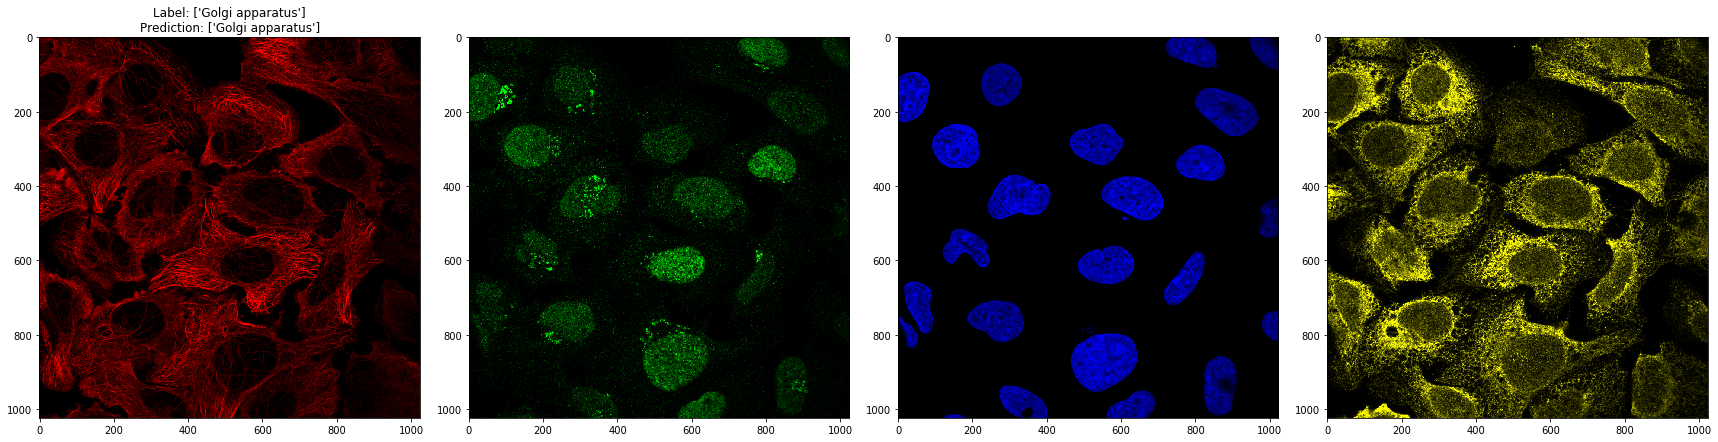

In [25]:
random_image_data = random.sample(images_data, 1)[0]
inference_on_image_data(random_image_data)

If you have downloaded the training data, then you can use the code below

In [26]:
unique_class_combinations = get_unique_classes("ALL")
sampled_class_combination = random.sample(unique_class_combinations, 1)[0]
sampled_image = get_image_from_class(sampled_class_combination, n_samples=1)[0]

In [27]:
image_data = {
    "image": sampled_image,
    "label": list(sampled_class_combination)
}

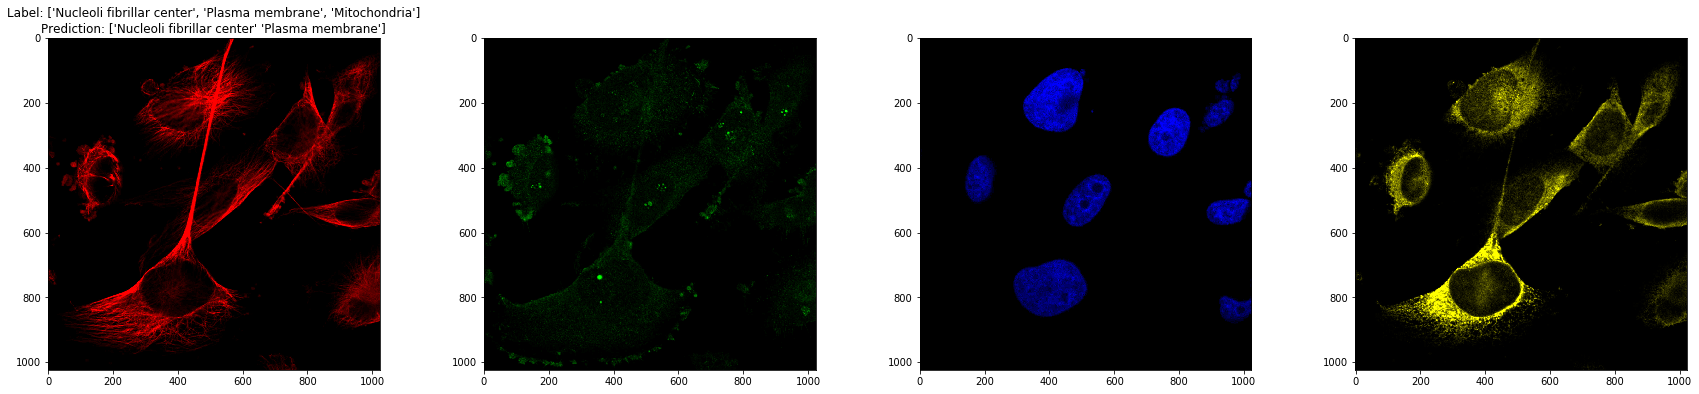

In [28]:
inference_on_image_data(image_data)